In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from sklearn.metrics import cohen_kappa_score
import xgboost as xgb
import gc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
%%time
test = pd.read_csv("data/raw/test.csv")
train_labels = pd.read_csv("data/raw/train_labels.csv")
train = pd.read_csv("data/raw/train.csv")
specs = pd.read_csv("data/raw/specs.csv")
submission = pd.read_csv("data/raw/sample_submission.csv")
print("Data Loaded!")

Data Loaded!
CPU times: user 55.2 s, sys: 2.37 s, total: 57.5 s
Wall time: 57 s


In [3]:
train.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK


In [4]:
train_labels.head(4)

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2


In [5]:
specs.head()

,event_id,info,args
0,2b9272f4,The end of system-initiated feedback (Correct)...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
1,df4fe8b6,The end of system-initiated feedback (Incorrec...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
2,3babcb9b,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
3,7f0836bf,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
4,ab3136ba,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."


In [6]:
specs['info'][1]

'The end of system-initiated feedback (Incorrect) event occurs when the game finishes delivering feedback to the player in response to an incorrect round attempt (pressing the go button with the incorrect answer). It contains information that describes the content of the instruction. These events are used to determine the effectiveness of the feedback. We can answer questions like, "how much time elapsed while the game was presenting feedback?"'

In [7]:
test.sample(5)

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
703636,3bf1cf26,35e6d30745fc5eb3,2019-08-01T16:01:52.266Z,"{""description"":""That bowl is too light!"",""iden...",962183dc,43,3120,151875,Happy Camel,Game,CRYSTALCAVES
1034273,de26c3a6,ce3bfe3a9fe661f7,2019-10-11T01:28:46.467Z,"{""growth"":[0,0,8,0,0],""flowers"":[0,2,8,8,8],""d...",e47bebac,201,4020,275691,Flower Waterer (Activity),Activity,TREETOPCITY
844716,d2278a3b,2286a90daddbb6b9,2019-09-22T23:29:47.368Z,"{""version"":""1.0"",""round"":0,""event_count"":1,""ga...",b6c3e1ab,1,2000,0,Bottle Filler (Activity),Activity,MAGMAPEAK
437012,7372e1a5,ea39d7f0f66a9ddb,2019-08-03T21:59:33.665Z,"{""coordinates"":{""x"":420,""y"":381,""stage_width"":...",6453e840,184,4070,223647,Chow Time,Game,CRYSTALCAVES
397632,0d1da71f,78e79a9f81e253cf,2019-09-04T20:53:18.482Z,"{""description"":""To make the sure dinosaur eats...",5a6f3de8,47,3110,80771,Chow Time,Game,CRYSTALCAVES


In [8]:
train['title'].nunique()

44

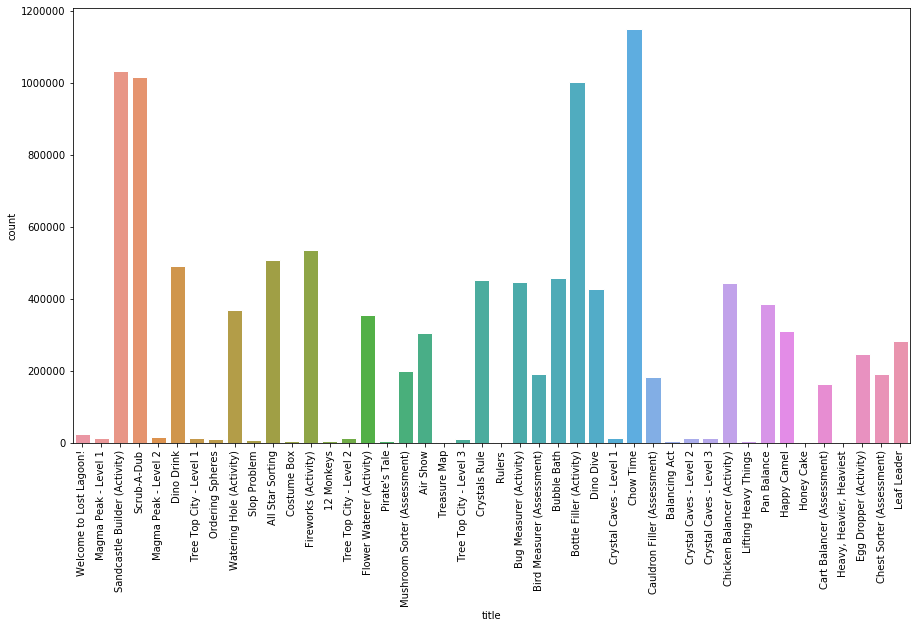

In [9]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=90)
sns.set()
sns.set(style="darkgrid")
ax = sns.countplot(x=train['title'], data=train)

**DATA PREPARATION**

**This part is taken from this kernel,check it out and upvote it if you like.**

https://www.kaggle.com/shahules/xgboost-starter-dsbowl

In [14]:
train_labels.drop(['num_correct','num_incorrect','accuracy','title'],axis=1,inplace=True)

In [11]:
train.drop(['event_data','date'],axis=1,inplace=True)

In [12]:
not_req=(set(train.installation_id.unique()) - set(train_labels.installation_id.unique()))
train = train[~train['installation_id'].isin(not_req)]
print(train.shape)

(7734558, 10)


In [13]:
def extract_time_features(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date
    df['month'] = df['timestamp'].dt.month
    df['hour'] = df['timestamp'].dt.hour
    df['year'] = df['timestamp'].dt.year
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    df['weekofyear'] = df['timestamp'].dt.weekofyear
    return df

In [14]:
def prepare_data(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['hour_of_day']=df['timestamp'].map(lambda x : int(x.hour))
    #one hot encoding on event code
    join_one=pd.get_dummies(df[['event_code','installation_id','game_session']],
                            columns=['event_code']).groupby(['installation_id','game_session'],as_index=False,sort=False).agg(sum)
    
    #dictionary to perform some aggregate functions after grouping
    agg={'event_count':sum,'hour_of_day':'mean','game_time':['sum','mean'],'event_id':'count'}
    
    join_two=df.drop(['timestamp'],axis=1).groupby(['installation_id','game_session'],as_index=False,sort=False).agg(agg)
    
    join_two.columns= [' '.join(col).strip() for col in join_two.columns.values]

    join_three=df[['installation_id','game_session','type','world','title']].groupby(['installation_id','game_session'],as_index=False,sort=False).first()
    
    join_four=(join_one.join(join_two.drop(['installation_id','game_session'],axis=1))). \
                        join(join_three.drop(['installation_id','game_session'],axis=1))
    return join_four

In [15]:
join_train=prepare_data(train)
cols=join_train.columns.to_list()[2:-3]
join_train[cols]=join_train[cols].astype('int16')

In [16]:
join_test=prepare_data(test)
cols=join_test.columns.to_list()[2:-3]
join_test[cols]=join_test[cols].astype('int16')

In [17]:
cols=join_test.columns[2:-8].to_list()
cols.append('event_id count')
cols.append('installation_id')

In [18]:
df=join_test[['hour_of_day mean','event_count sum','game_time mean','game_time sum',
    'installation_id']].groupby('installation_id',as_index=False,sort=False).agg('mean')

df_two=join_test[cols].groupby('installation_id',as_index=False,
                               sort=False).agg('sum').drop('installation_id',axis=1)

df_three=join_test[['title','type','world','installation_id']].groupby('installation_id',
         as_index=False,sort=False).last().drop('installation_id',axis=1)
        

In [19]:
final_train=pd.merge(train_labels,join_train,on=['installation_id','game_session'],
                                         how='left').drop(['game_session'],axis=1)

#final_test=join_test.groupby('installation_id',as_index=False,sort=False).last().drop(['game_session','installation_id'],axis=1)
final_test=(df.join(df_two)).join(df_three).drop('installation_id',axis=1)

In [21]:
final_train.head()

,installation_id,title_x,num_correct,num_incorrect,accuracy,accuracy_group,event_code_2000,event_code_2010,event_code_2020,event_code_2025,...,event_code_5000,event_code_5010,event_count sum,hour_of_day mean,game_time sum,game_time mean,event_id count,type,world,title_y
0,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3,1,1,1,1,...,0,0,630,5,26928,10131,35,Assessment,TREETOPCITY,Mushroom Sorter (Assessment)
1,0006a69f,Bird Measurer (Assessment),0,11,0.0,0,1,0,1,0,...,0,0,3828,5,27366,-17765,87,Assessment,TREETOPCITY,Bird Measurer (Assessment)
2,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3,1,1,1,1,...,0,0,1176,5,-10305,17534,48,Assessment,TREETOPCITY,Mushroom Sorter (Assessment)
3,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2,1,1,1,1,...,0,0,903,20,6334,12633,42,Assessment,TREETOPCITY,Mushroom Sorter (Assessment)
4,0006a69f,Bird Measurer (Assessment),1,0,1.0,3,1,1,2,0,...,0,0,528,20,29907,17318,32,Assessment,TREETOPCITY,Bird Measurer (Assessment)


In [20]:
df=final_train[['hour_of_day mean','event_count sum','game_time mean','game_time sum','installation_id']]. \
    groupby('installation_id',as_index=False,sort=False).agg('mean')

df_two=final_train[cols].groupby('installation_id',as_index=False,
                                 sort=False).agg('sum').drop('installation_id',axis=1)

df_three=final_train[['accuracy_group','title','type','world','installation_id']]. \
        groupby('installation_id',as_index=False,sort=False). \
        last().drop('installation_id',axis=1)

final_train=(df.join(df_two)).join(df_three).drop('installation_id',axis=1)

KeyError: "['title'] not in index"

In [25]:
#concat train and test and Label Encode Categorical Columns

final=pd.concat([final_train,final_test])
encoding=['type','world','title']
for col in encoding:
    lb=LabelEncoder()
    lb.fit(final[col])
    final[col]=lb.transform(final[col])
    
final_train=final[:len(final_train)]
final_test=final[len(final_train):]

In [26]:
X_train=final_train.drop('accuracy_group',axis=1)
y_train=final_train['accuracy_group']

**Model**

In [27]:
%%time

pars = {
    'colsample_bytree': 0.5,                 
    'learning_rate': 0.01,
    'max_depth': 10,
    'subsample': 0.5,
    'objective':'multi:softprob',
    'num_class':4
}

kf = KFold(n_splits=10, shuffle=True, random_state=42)
y_pre=np.zeros((len(final_test),4),dtype=float)
final_test=xgb.DMatrix(final_test.drop('accuracy_group',axis=1))


for train_index, val_index in kf.split(X_train):
    train_X = X_train.iloc[train_index]
    val_X = X_train.iloc[val_index]
    train_y = y_train[train_index]
    val_y = y_train[val_index]
    xgb_train = xgb.DMatrix(train_X, train_y)
    xgb_eval = xgb.DMatrix(val_X, val_y)
    
    xgb_model = xgb.train(pars,
                  xgb_train,
                  num_boost_round=10000,
                  evals=[(xgb_train, 'train'), (xgb_eval, 'val')],
                  verbose_eval=False,
                  early_stopping_rounds=100
                 )
    
    val_X=xgb.DMatrix(val_X)
    pred_val=[np.argmax(x) for x in xgb_model.predict(val_X)]
    
    print('choen_kappa_score :',cohen_kappa_score(pred_val,val_y,weights='quadratic'))
    
    pred=xgb_model.predict(final_test)
    y_pre+=pred
    
pred = np.asarray([np.argmax(line) for line in y_pre])

choen_kappa_score : 0.7144233812490848
choen_kappa_score : 0.6871261592493003
choen_kappa_score : 0.7335379814144867
choen_kappa_score : 0.7694042339738895
choen_kappa_score : 0.7583586864297691
choen_kappa_score : 0.7287254684243938
choen_kappa_score : 0.739731873137228
choen_kappa_score : 0.757039072151642
choen_kappa_score : 0.6972238530571165
choen_kappa_score : 0.7309292680142623
CPU times: user 2min 26s, sys: 3.88 s, total: 2min 30s
Wall time: 38.4 s


In [28]:
sub=pd.DataFrame({'installation_id':submission.installation_id,'accuracy_group':pred})
sub.to_csv('submission.csv',index=False)